AE with dense layer

In [1]:
import numpy as np
import itertools
import os, sys
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
import gpustat
try:
    gpustat.print_gpustat()
except:
    pass

mustafar  Wed Jul  3 20:28:22 2019
[0] GeForce GTX 1070 | 60'C,   0 % |     0 /  8114 MB |
[1] GeForce GTX 1070 | 48'C,   0 % |     0 /  8114 MB |


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
sys.path.append('../lib')

In [5]:
from progressBar import ProgressBar
from utils import EarlyStopping

In [6]:
dnd = []

## Get the dataset

In [7]:
from torch.utils import data

In [8]:
class Dataset(data.Dataset):
    def __init__(self, names = 'SM', 
                 template='../data/20190702_20part_PtOrder_v1/{}.npy',
                 N_part = 20,
                 N_features = 5
                ):
        if names == 'SM':
            self.SM_names = ['Wlnu', 'qcd', 'ttbar', 'Zll']
            names = self.SM_names
        self.names = names
        
        self.feature_names = ['Pt', 'eta', 'phi', 'charge', 'pId'][:N_features]
        
        for i, n in enumerate(names):
            ins = np.load(template.format(n)).astype(np.float32)[:,:N_part,:N_features]
            lbs = i*np.ones(ins.shape[0]).astype(np.int8)
            
            print(n, ':', str(ins.shape))
            
            if i == 0:
                self.inputs = ins
                self.labels = lbs
            else:
                self.inputs = np.concatenate((self.inputs, ins))
                self.labels = np.concatenate((self.labels, lbs))
    
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.inputs[idx]

In [9]:
dataset = {}
# Use to do validation split
# torch.utils.data.random_split(dataset, lengths)
dataset['train'] = Dataset(names=['Wlnu'], N_part=20, N_features=5)

Wlnu : (100000, 20, 5)


## Define the model

In [10]:
class AEDenseNet(nn.Module):
    def __init__(self, N_part, N_features, dim_hidden, dim_latent, verbose = False):
        super(AEDenseNet, self).__init__()
        self.verbose = verbose
        
        self.No = N_part
        self.p = N_features
        self.Nk = dim_latent
        
        self.encoder_modules = nn.ModuleDict({
            'PhiE': self.build_dense(dim_in=self.p*self.No,
                                   dim_out=self.Nk,
                                   dim_hidden=dim_hidden)
        })
        
        
        self.decoder_modules = nn.ModuleDict({
            'PhiD': self.build_dense(dim_in=self.Nk,
                                   dim_out=self.p*self.No,
                                   dim_hidden=dim_hidden),
            'ChargeDec': self.build_dense(dim_in=2,
                                   dim_out=3),
            'pdgIdDec': self.build_dense(dim_in=2,
                                   dim_out=5)
        })
        
        
        self.onGPU = False
          
    def build_dense(self, dim_in, dim_out, dim_hidden=0):
        if dim_hidden:
            net = nn.Sequential(
                                nn.Linear(dim_in, dim_hidden),
#                                 nn.ELU(),
#                                 nn.Linear(dim_hidden, dim_hidden),
                                nn.ReLU(),
                                nn.Linear(dim_hidden, dim_out),
                              )
        else:
            d_avg = int(0.5*(dim_in + dim_out))
            net = nn.Sequential(
                                nn.Linear(dim_in, d_avg),
                                nn.ReLU(),
                                nn.Linear(d_avg, dim_out),
                              )
        return net
        
    def encode(self, x):
        z_raw = self.encoder_modules['PhiE'](x.contiguous().view(-1, self.p*self.No))
        z = F.hardtanh(z_raw, min_val=-5, max_val=5)
        return z
    
    def decode(self, z):
        x_raw = self.decoder_modules['PhiD'](z).view(-1, self.No, self.p)
        
        # --- Formatting x ----
        # pt
        pt = 1. + F.elu(x_raw[:,:,0]).view(-1, self.No, 1)
        # eta
        eta = F.hardtanh(x_raw[:,:,1], min_val=-5, max_val=5).view(-1, self.No, 1)
        # phi
        phi = torch.fmod(torch.abs(x_raw[:,:,2]), 6.2831853072).view(-1, self.No, 1) - 3.14159265359
        # charge
        charge_cat = F.softmax(self.decoder_modules['ChargeDec'](x_raw[:,:,3:].view(-1,2)), dim=1)
        charge = torch.argmax(charge_cat, dim=1).view(-1, self.No, 1) - 1.
        # pId
        pId_cat = F.softmax(self.decoder_modules['pdgIdDec'](x_raw[:,:,3:].view(-1,2)), dim=1)
        pId = torch.argmax(pId_cat, dim=1).view(-1, self.No, 1)
        
        x = torch.cat((pt,eta, phi, charge.float(), pId.float()), 2)
        return x
        
    
    def forward(self, x):
        z = self.encode(x)
        x_prime = self.decode(z)
        return x_prime
    
    def initWeights(self):
        def weights_init(M):
            if hasattr(M, 'weight'):
                nn.init.xavier_normal_(M.weight.data)
        
        self.apply(weights_init)
    
    def useGPU(self, N_GPU=1):
        if torch.cuda.is_available():
            print('Current device: {} ({} available)'.format(torch.cuda.current_device(), 
                                                             torch.cuda.device_count()))
            self.N_GPU = N_GPU
            torch.cuda.empty_cache()
            self.cuda(N_GPU)
            gpustat.print_gpustat()
            
            self.onGPU = True
        else: 
            print('GPU not available')

In [11]:
Latent_dimension = 60 #dataset['train'].inputs.shape[1]
Hidden_dimension = 80 #int(0.7*(Latent_dimension + dataset['train'].inputs.shape[1]*dataset['train'].inputs.shape[2]))

model = AEDenseNet(
                   N_part=dataset['train'].inputs.shape[1],
                   N_features=dataset['train'].inputs.shape[2],
                   dim_hidden=Hidden_dimension,
                   dim_latent=Latent_dimension
                  )

print(model)
trainablePars = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nTrainable parameters:', trainablePars)

# model.initWeights()

AEDenseNet(
  (encoder_modules): ModuleDict(
    (PhiE): Sequential(
      (0): Linear(in_features=100, out_features=80, bias=True)
      (1): ReLU()
      (2): Linear(in_features=80, out_features=60, bias=True)
    )
  )
  (decoder_modules): ModuleDict(
    (ChargeDec): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=3, bias=True)
    )
    (PhiD): Sequential(
      (0): Linear(in_features=60, out_features=80, bias=True)
      (1): ReLU()
      (2): Linear(in_features=80, out_features=100, bias=True)
    )
    (pdgIdDec): Sequential(
      (0): Linear(in_features=2, out_features=3, bias=True)
      (1): ReLU()
      (2): Linear(in_features=3, out_features=5, bias=True)
    )
  )
)

Trainable parameters: 25964


In [12]:
model.useGPU(0)

Current device: 0 (2 available)
mustafar  Wed Jul  3 20:28:24 2019
[0] GeForce GTX 1070 | 61'C,   7 % |   447 /  8114 MB | ocerri(437M)
[1] GeForce GTX 1070 | 48'C,   0 % |    10 /  8114 MB |


## Loss

In [13]:
criterion = nn.L1Loss()

## Training

In [14]:
training_params = {'batch_size': 1000,
                   'shuffle': True,
                   'num_workers': 0
                  }

max_epochs = 50

In [15]:
torch.autograd.set_detect_anomaly(True);

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )

# Early stopping
earlyStopping = EarlyStopping(patient=10)

In [17]:
optimizer.zero_grad()
data_train_iter = data.DataLoader(dataset['train'], **training_params)

train_loss = []
for epoch in range(1, max_epochs+1):
    batch_loss = []
    pb = ProgressBar(len(data_train_iter), percentPrecision=5, headLabel='Epoch {}: '.format(epoch-1))
    for local_x, _ in data_train_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        
        x_prime = model(local_x)
        loss = criterion(local_x.view(-1, model.p*model.No), x_prime.view(-1, model.p*model.No))
        batch_loss.append(loss.item())
        
        tail_label = 'Loss: {:2.2e}'.format(loss.item())
        if len(train_loss) > 0:
            tail_label += ' ({:2.2e})'.format(loss.item() - train_loss[-1][-1])
        pb.show(len(batch_loss)-1, tail_label=tail_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    aux_loss = 0
    N_batches = 0
    for local_x, _ in data_train_iter:
        if model.onGPU:
            local_x = local_x.cuda(model.N_GPU)
        x_prime = model(local_x)
        loss = criterion(local_x.view(-1, model.p*model.No), x_prime.view(-1, model.p*model.No))
        aux_loss += loss.item()
        N_batches += 1
    batch_loss.append(aux_loss/N_batches)
    
    printout = 'Loss: {:2.2e}'.format(batch_loss[-1])
    if len(train_loss) > 0:
        printout += ' - Delta: {:2.2e}'.format(batch_loss[-1] - train_loss[-1][-1])
    if len(train_loss) > 1:
        d2L_de2 = batch_loss[-1] - 2*train_loss[-1][-1] + train_loss[-2][-1]
        printout +=' - Trend: {:2.2e}'.format(d2L_de2)
    print(printout+'\n')
    
    train_loss.append(batch_loss)
    
    if not earlyStopping.check(batch_loss[-1]):
        break

    scheduler.step(batch_loss[-1])

Epoch 0: [####################]  100% - Tot. time: 3.3 s            
Loss: 1.37e+00

Epoch 1: [####################]  100% - Tot. time: 3.3 s                        
Loss: 1.08e+00 - Delta: -2.93e-01

Epoch 2: [####################]  100% - Tot. time: 3.2 s                        
Loss: 9.69e-01 - Delta: -1.06e-01 - Trend: 1.86e-01

Epoch 3: [####################]  100% - Tot. time: 3.3 s                        
Loss: 9.08e-01 - Delta: -6.15e-02 - Trend: 4.47e-02

Epoch 4: [####################]  100% - Tot. time: 3.3 s                        
Loss: 8.74e-01 - Delta: -3.36e-02 - Trend: 2.79e-02

Epoch 5: [####################]  100% - Tot. time: 3.3 s                        
Loss: 8.51e-01 - Delta: -2.33e-02 - Trend: 1.03e-02

Epoch 6: [####################]  100% - Tot. time: 3.2 s                        
Loss: 8.34e-01 - Delta: -1.67e-02 - Trend: 6.59e-03

Epoch 7: [####################]  100% - Tot. time: 3.3 s                        
Loss: 8.24e-01 - Delta: -9.85e-03 - Trend: 6.87e

KeyboardInterrupt: 

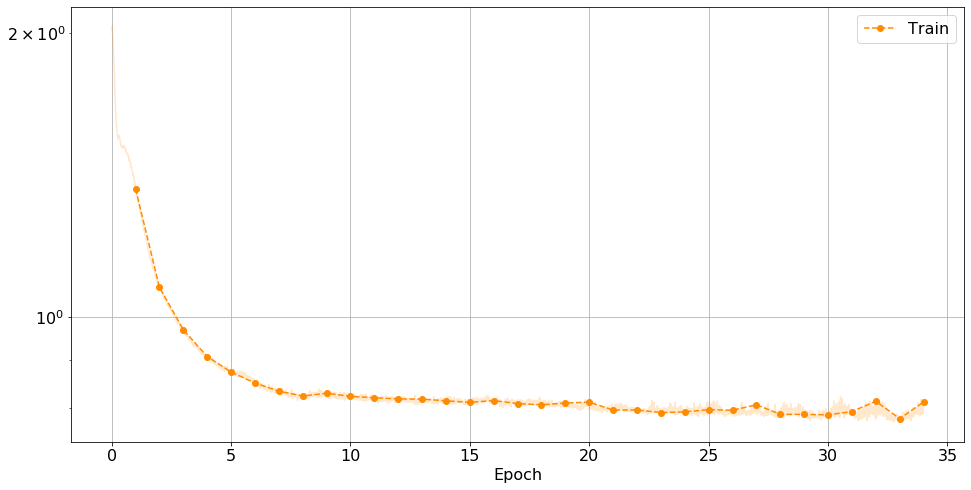

In [18]:
train_loss = np.array(train_loss)
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(16,8))

train_loss_flat = train_loss.flatten()
x = np.arange(1, train_loss_flat.shape[0]+1) * float(train_loss.shape[0])/train_loss_flat.shape[0]
plt.plot(x, train_loss_flat, '-', alpha=0.2, color='darkorange')

x = np.arange(1, train_loss.shape[0]+1)
plt.plot(x, train_loss[:,-1], 'o--', label='Train', color='darkorange')

plt.xlabel('Epoch')
plt.grid()
plt.legend(loc='best')
plt.yscale('log')
# f.savefig('plots/TrainingHistory_VAE_all-in-one_v'+VAEversion+'.png')

# f = open('TrainingHistory_VAE_all-in-one_v'+VAEversion+'.pkl', 'w')
# pickle.dump(fit_report.history, f, pickle.HIGHEST_PROTOCOL)
# f.close()

# Convergence check

In [19]:
x = dataset['train'].inputs
model.eval()
if model.useGPU:
    x_prime = model(torch.from_numpy(x[:10000]).cuda()).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000]).cuda()).cpu().detach().numpy()
else:
    x_prime = model(torch.from_numpy(x[:10000])).cpu().detach().numpy()
    z = model.encode(torch.from_numpy(x[:10000])).cpu().detach().numpy()

### Latent space

/afs/cern.ch/user/o/ocerri/mwork/miniconda2/envs/PartAN/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


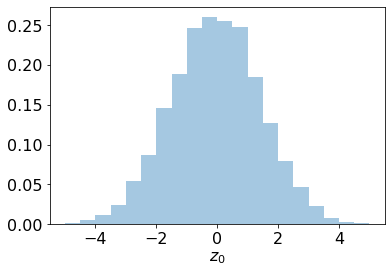

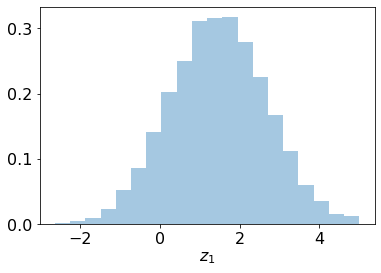

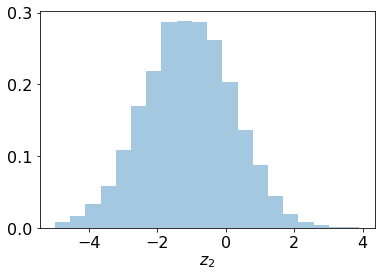

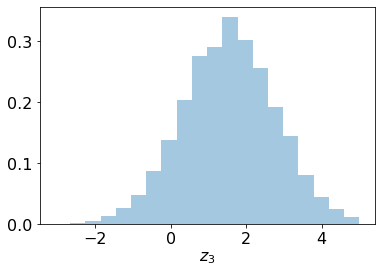

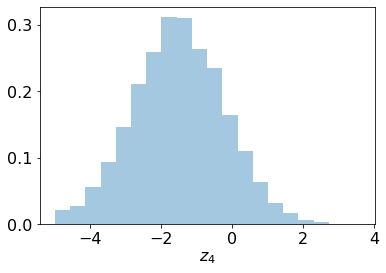

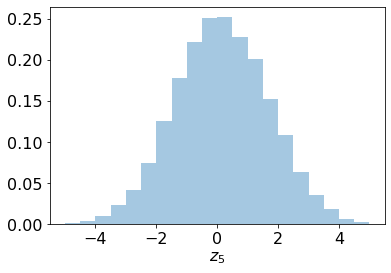

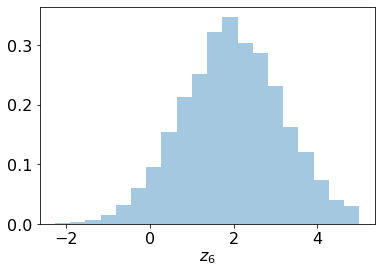

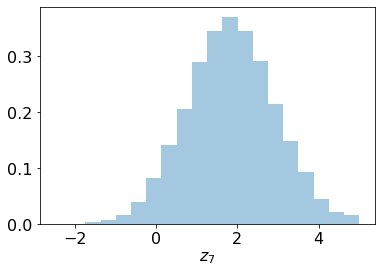

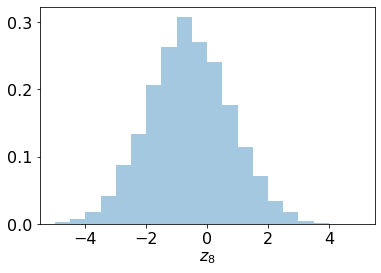

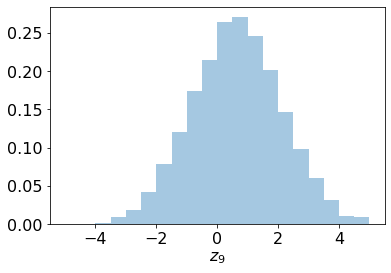

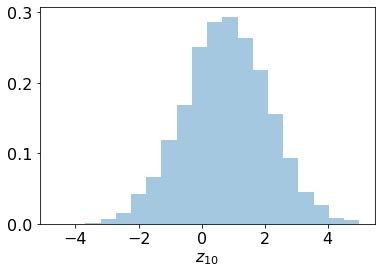

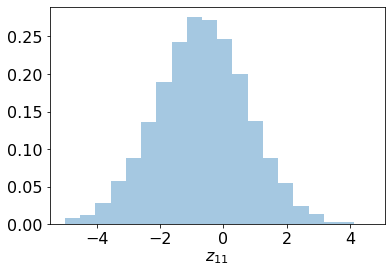

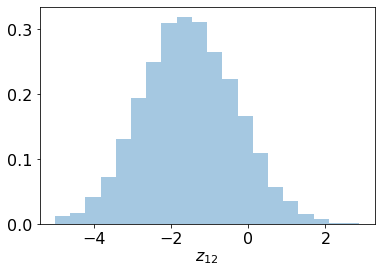

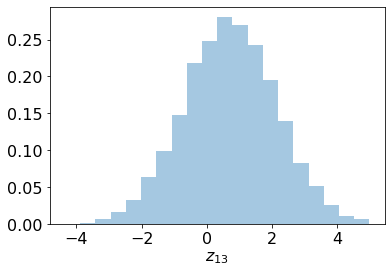

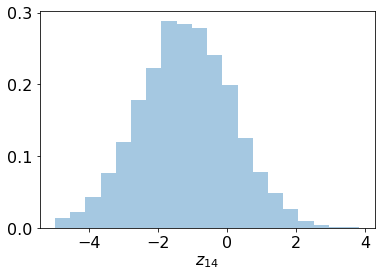

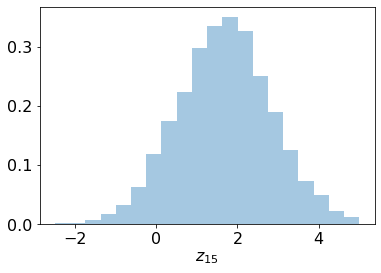

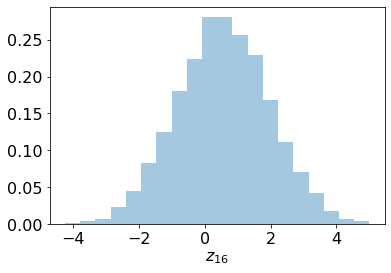

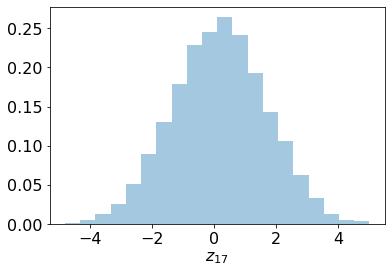

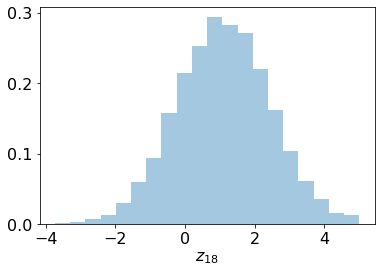

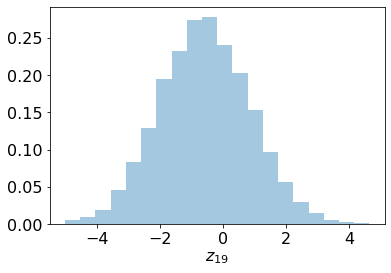

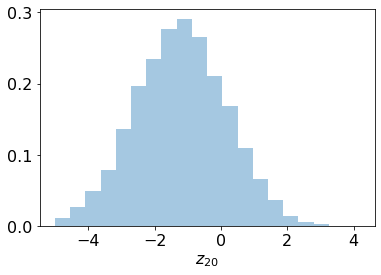

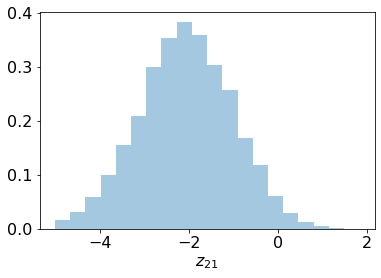

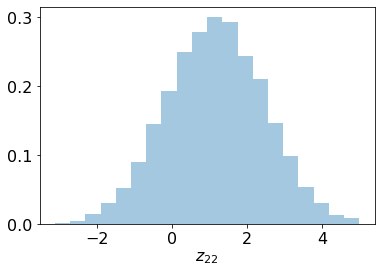

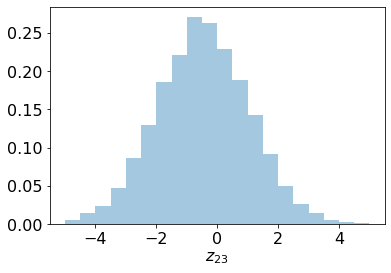

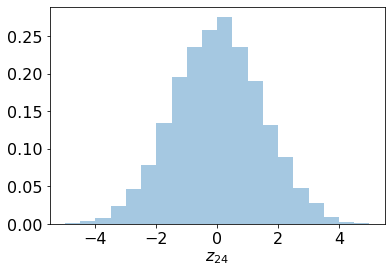

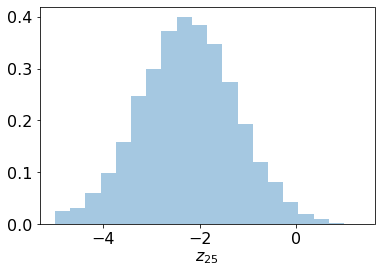

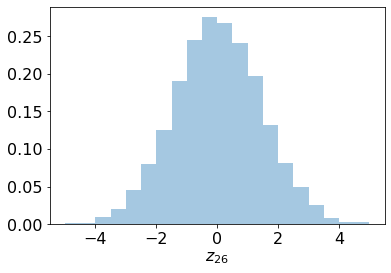

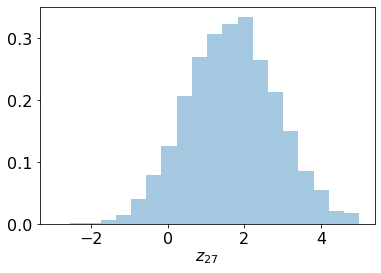

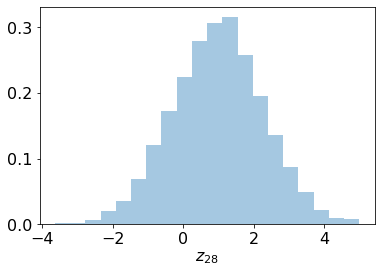

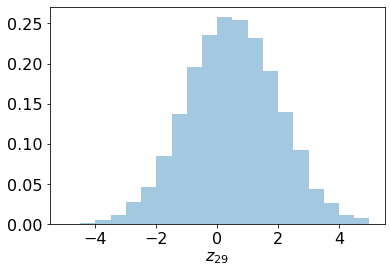

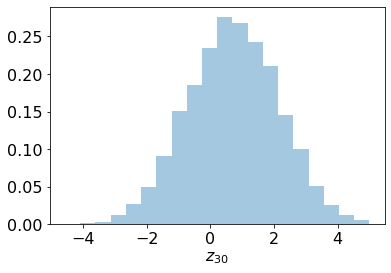

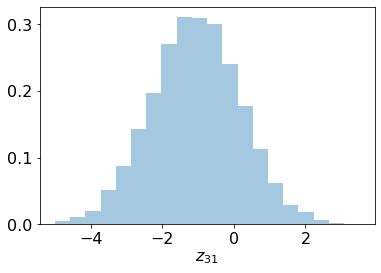

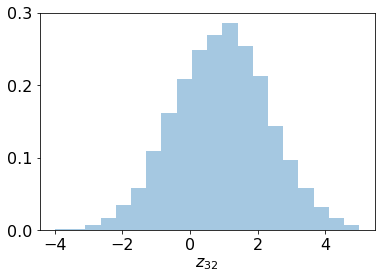

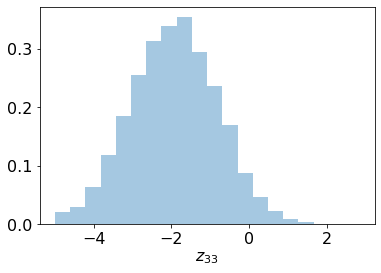

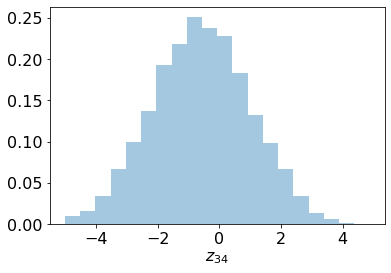

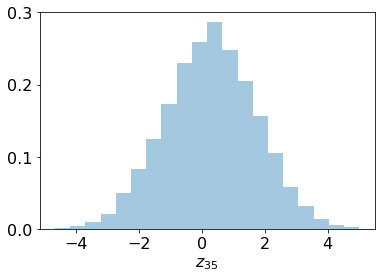

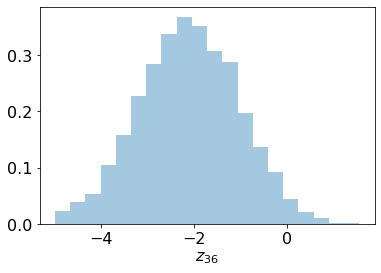

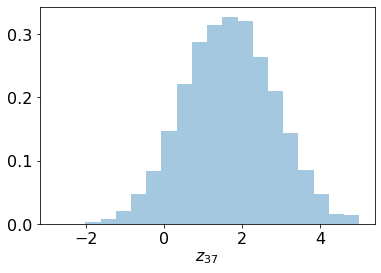

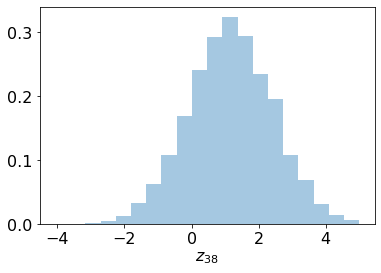

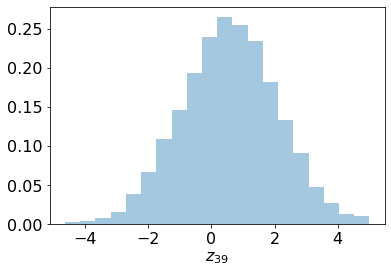

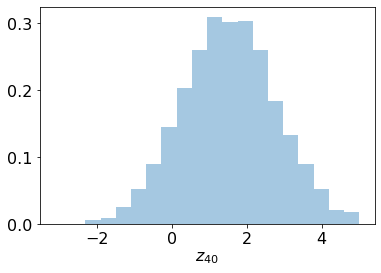

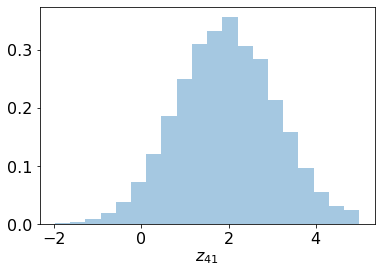

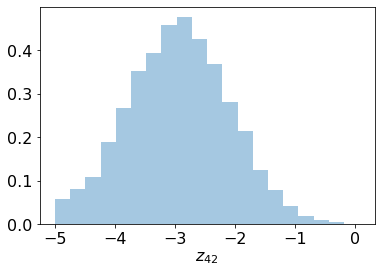

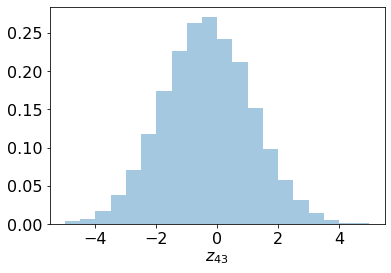

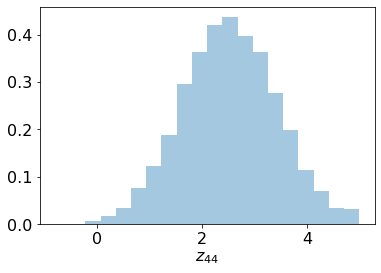

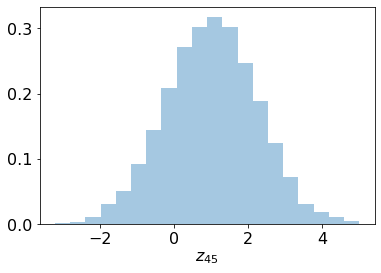

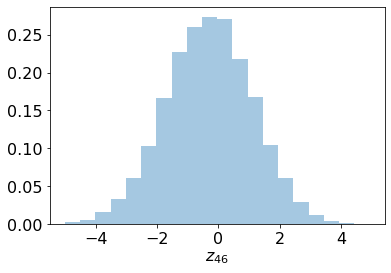

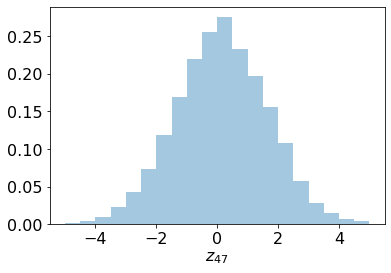

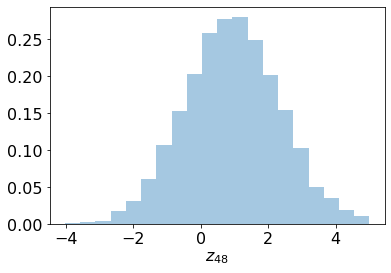

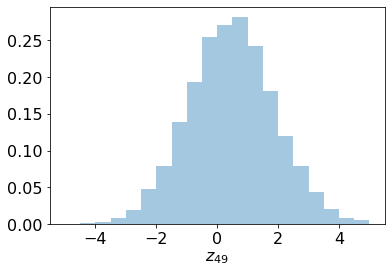

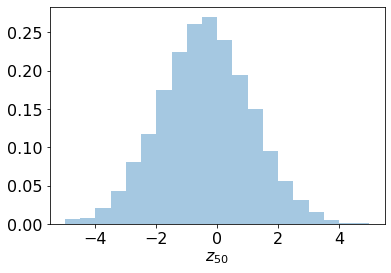

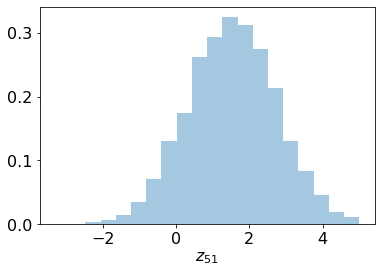

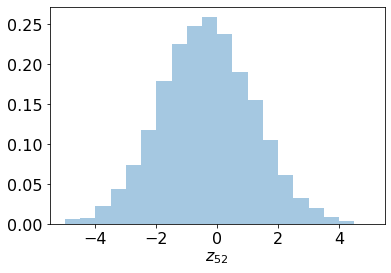

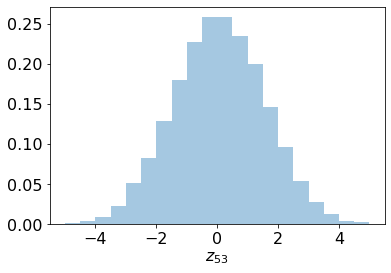

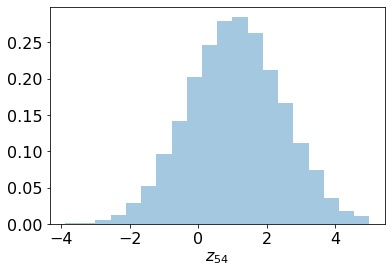

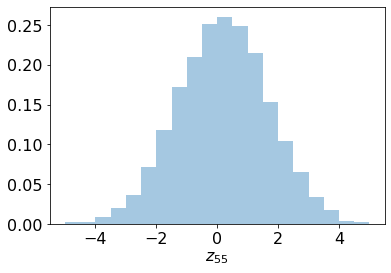

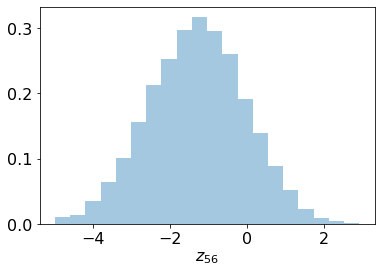

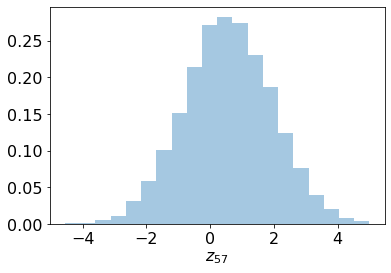

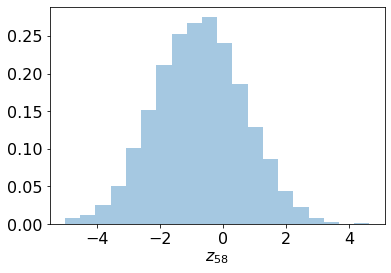

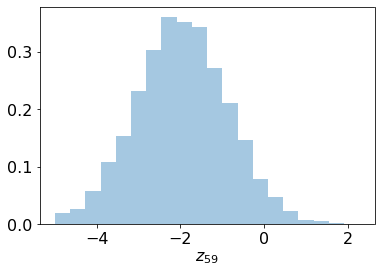

In [20]:
for i in range(z.shape[1]):
    x_aux = z[:,i]
    f = plt.figure(i)
    r = (np.min(x_aux), np.max(x_aux))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('$z_{{{}}}$'.format(i))
    dnd.append(f)

### Output features

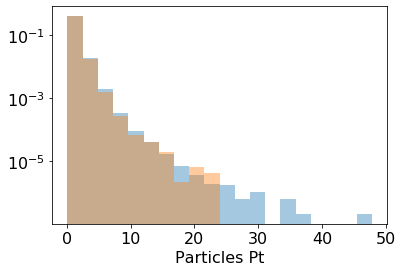

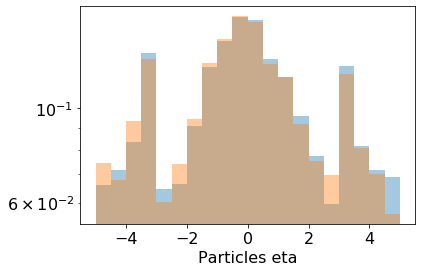

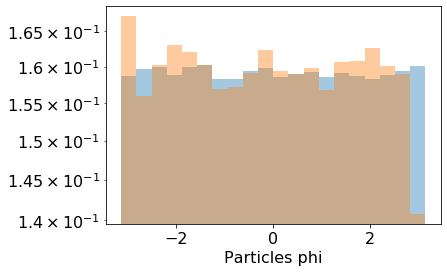

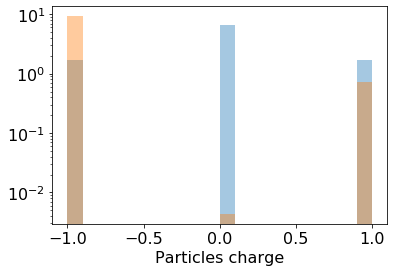

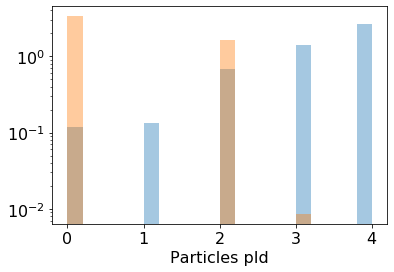

In [21]:
for i in range(x_prime.shape[2]):
    x_aux = x[:,:,i].flatten()
    xp_aux = x_prime[:,:,i].flatten()
    f = plt.figure(i)
    r = (min(np.min(x_aux), np.min(xp_aux)), max(np.max(x_aux), np.max(xp_aux)))
    plt.hist(x_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.hist(xp_aux, bins=20, range=r, alpha=0.4, density=True)
    plt.xlabel('Particles ' + dataset['train'].feature_names[i])
    plt.yscale('log')
    dnd.append(f)